# Mapas - Seguro rural

In [ ]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install jenkspy
!pip install pyshp

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import scipy.stats as stats
import jenkspy

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para gráficos
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches, colors
from matplotlib.lines import Line2D
from matplotlib.collections import EventCollection
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection  
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
mpl.rcdefaults()


import warnings
warnings.filterwarnings("ignore")

import shapefile
from google.colab import drive, files

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Descomente para clonar o repositório com os dados utilisados
!git clone -l -s git://github.com/walefmachado/seguro_rural_espacial.git dados
%cd dados
!ls

Cloning into 'dados'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 136 (delta 26), reused 128 (delta 18), pack-reused 0
Receiving objects: 100% (136/136), 47.94 MiB | 32.51 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/dados
anexos	cap1  cap2  dados  dissertacao	figuras  README.md  scripts


# Dados

### Dados de seguro rural

In [ ]:
#link = 'https://raw.githubusercontent.com/walefmachado/spreg_rural_insurance/main/dados/'
link = 'https://raw.githubusercontent.com/walefmachado/seguro_rural_espacial/main/dados/'

In [ ]:
dados_br = pd.read_csv(link+'/dados_06_19.csv')

### Dados para espacial 

In [ ]:
cod = pd.read_csv(link+'/codigos-mun.csv')

br = geopandas.read_file(link+'/br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

dados_br = cod_dados.merge(dados_br, on='mun', how='left')
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop(['rm', 'nome_mun_y', 'nome_meso_y'], axis = 1)
dados_br.rename(columns = {'nome_mun_x':'nome_mun', 'nome_meso_x':'nome_meso' }, inplace = True)

In [ ]:
# Para baixar os dados:

#from google.colab import files
#dados_br.to_csv('dados_br.csv', index=False)
#files.download('dados_br.csv')

In [ ]:
#img=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_3.png')
img=mpimg.imread('https://github.com/walefmachado/seguro_rural_espacial/blob/main/figuras/rosa_dos_ventos_3.png?raw=true')

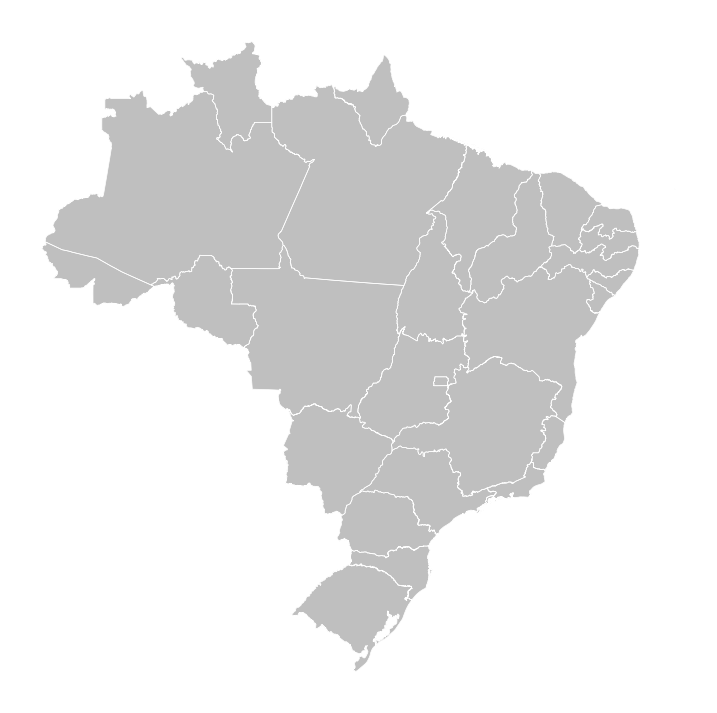

In [ ]:
#Regioes geograficas
sf = shapefile.Reader('/content/dados/dados/estados_2010.shp')
shapes = sf.shapes()
Nshp = len(shapes)

ptchs   = []
for nshp in range(Nshp):
    pts     = np.array(shapes[nshp].points)
    prt     = shapes[nshp].parts
    par     = list(prt) + [pts.shape[0]]

    for pij in range(len(prt)):
       ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))

#UF
sf_uf = shapefile.Reader('/content/dados/dados/estados_2010.shp')
shapes = sf.shapes()
shapes_uf = sf_uf.shapes()
Nshp_uf = len(shapes_uf)

ptchs_uf   = []
for nshp_uf in range(Nshp_uf):
    pts_uf     = np.array(shapes_uf[nshp_uf].points)
    prt_uf     = shapes_uf[nshp_uf].parts
    par_uf     = list(prt_uf) + [pts_uf.shape[0]]

    for pij_uf in range(len(prt_uf)):
       ptchs_uf.append(Polygon(pts_uf[par_uf[pij_uf]:par_uf[pij_uf+1]]))


fig     = plt.figure(figsize = (9,9))
ax      = fig.add_subplot(111)

ax.add_collection(PatchCollection(ptchs,facecolor='0.75', edgecolor='w', linewidths=0))
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))
ax.axis('auto'); ax.axis('off')
plt.show()
# Fonte: http://www.phme.it/wilt/2017/05/06/dynamic-mapping-with-shapefiles-and-python/

In [ ]:
variaveis = ['apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil',
             'total_subvencao_mil', 'valor_indenizacoes_pagas_mil',
             'sinistralidade_media', 'taxa_media', 'apolices_indenizadas'] # 
anos = dados_br.ano.unique()

In [ ]:
dados_19 = dados_br[dados_br['ano']==2019]

In [ ]:
color_list = ["lightgrey", "darkgrey", "gray", "dimgrey", "black"]
#color_list = ["#440154", "#3b528b", "#21918c", "#5ec962", "#fde725"] 
colors_map = colors.LinearSegmentedColormap.from_list("", color_list)

In [ ]:
for variavel in variaveis:
    referencia = jenkspy.jenks_breaks(dados_19[variavel][dados_19[variavel] != 0], nb_class=4)   #Fisher Jenks a partir dos dados de 2019
    referencia[0] = 0 
    referencia[4] = dados_br[variavel].max()
    if variavel == 'taxa_media':
        labels = ['0','0 - '+str(round(referencia[1],1)),
                  str(round(referencia[1],1)) + ' - '+ str(round(referencia[2],1)), 
                str(round(referencia[2],1)) + ' - '+ str(round(referencia[3],1)), 
                str(round(referencia[3],1)) + ' - '+ str(round(referencia[4],1))]     #rótulos da legenda
        classif = mc.UserDefined(dados_br[variavel].values,referencia)
        cl = [labels[i] for i in classif.yb]
        dados_br = dados_br.assign(cl = cl)
        dados_br.cl = pd.Categorical(dados_br.cl,ordered=True,categories=labels)
    else:
        labels = ['0','1 - '+str(round(referencia[1])),
                str(round(referencia[1])) + ' - '+ str(round(referencia[2])), 
                str(round(referencia[2])) + ' - '+ str(round(referencia[3])), 
                str(round(referencia[3])) + ' - '+ str(round(referencia[4]))]     #rótulos da legenda
        classif = mc.UserDefined(dados_br[variavel].values,referencia)
        cl = [labels[i] for i in classif.yb]
        dados_br = dados_br.assign(cl = cl)
        dados_br.cl = pd.Categorical(dados_br.cl,ordered=True,categories=labels)

    print(referencia, labels)

[0, 66.0, 213.0, 474.0, 1275.0] ['0', '1 - 66', '66 - 213', '213 - 474', '474 - 1275']
[0, 10632044.75, 33823200.809999995, 87736314.85, 1415464375.4] ['0', '1 - 10632045', '10632045 - 33823201', '33823201 - 87736315', '87736315 - 1415464375']
[0, 842901.6600000001, 2824740.7100000004, 7768313.6099999985, 29156880.45] ['0', '1 - 842902', '842902 - 2824741', '2824741 - 7768314', '7768314 - 29156880']
[0, 297754.97, 1002442.75, 2586856.9400000004, 17171901.099999998] ['0', '1 - 297755', '297755 - 1002443', '1002443 - 2586857', '2586857 - 17171901']
[0, 380887.36, 1167738.63, 3374248.3, 37201500.7] ['0', '1 - 380887', '380887 - 1167739', '1167739 - 3374248', '3374248 - 37201501']
[0, 7.87, 19.7, 39.59, 821.42] ['0', '1 - 8', '8 - 20', '20 - 40', '40 - 821']
[0, 0.511, 1.465, 2.878, 190.95999999999995] ['0', '0 - 0.5', '0.5 - 1.5', '1.5 - 2.9', '2.9 - 191.0']
[0, 10.0, 29.0, 69.0, 777.0] ['0', '1 - 10', '10 - 29', '29 - 69', '69 - 777']


In [ ]:
for variavel in variaveis:
    referencia = jenkspy.jenks_breaks(dados_19[variavel][dados_19[variavel] != 0], nb_class=4)   #Fisher Jenks a partir dos dados de 2019
    referencia[0] = 0 
    referencia[4] = dados_br[variavel].max()
    if variavel == 'taxa_media':
        labels = ['0','0 - '+str(round(referencia[1],1)),
                  str(round(referencia[1],1)) + ' - '+ str(round(referencia[2],1)), 
                str(round(referencia[2],1)) + ' - '+ str(round(referencia[3],1)), 
                str(round(referencia[3],1)) + ' - '+ str(round(referencia[4],1))]     #rótulos da legenda
        classif = mc.UserDefined(dados_br[variavel].values,referencia)
        cl = [labels[i] for i in classif.yb]
        dados_br = dados_br.assign(cl = cl)
        dados_br.cl = pd.Categorical(dados_br.cl,ordered=True,categories=labels)
    else:
        labels = ['0','1 - '+str(round(referencia[1])),
                str(round(referencia[1])) + ' - '+ str(round(referencia[2])), 
                str(round(referencia[2])) + ' - '+ str(round(referencia[3])), 
                str(round(referencia[3])) + ' - '+ str(round(referencia[4]))]     #rótulos da legenda
        classif = mc.UserDefined(dados_br[variavel].values,referencia)
        cl = [labels[i] for i in classif.yb]
        dados_br = dados_br.assign(cl = cl)
        dados_br.cl = pd.Categorical(dados_br.cl,ordered=True,categories=labels)
    
    f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) 
    anos = dados_br.ano.unique()
    axs = axs.flatten()
    for i, ano in enumerate(anos):
        ax = axs[i]
        dados_br[dados_br['ano']==ano].plot(column='cl', ax=ax, legend=False, categorical=True, cmap=colors_map); # plot
        ax.set_axis_off()
        ax.set_title(ano, fontsize=30)
        ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
    lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'
    axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(1.85, 0.75), frameon=False, prop={'size': 30})
    axs[14].set_axis_off()
    axs[15].set_axis_off()
    axs[15].imshow(img)
    plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
    print(variavel)
    plt.show();

In [ ]:
apol_0 = []
for i in anos:
    apol_0.append(len(dados_br[dados_br['ano']==i].query('apolices_contratadas ==0')))

In [ ]:
print(apol_0)

[4762, 4293, 3644, 3692, 3808, 3752, 3697, 3142, 2836, 3916, 3279, 3427, 3416, 3149]


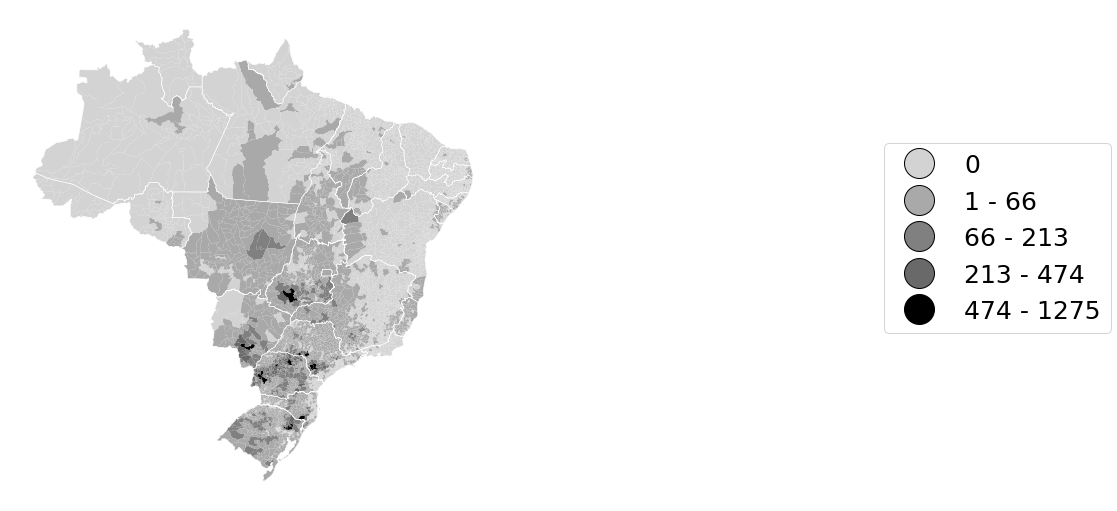

In [ ]:
# Laboratório de gráfico 
f, ax = plt.subplots(figsize=(10,10)) # 
dados_br[dados_br['ano']==2019].plot(column='cl', ax=ax, figsize=(10, 10), cmap=colors_map)
ax.set_axis_off()
#ax.set_title(ano, fontsize=20)
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, markeredgecolor='black', linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'
ax.legend(lines, labels,loc='botton left', bbox_to_anchor=(2, 0.75),  prop={'size': 25})
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))
nome_figura = 'mapas_tematicos_' + variavel +  '.png'
plt.show();

## Mapas LISA

In [ ]:
dados_lisa = dados_br
dados_lisa.drop(index=dados_lisa[dados_lisa['mun'] == 2605459].index, inplace=True) # retira F. Noronha e Ilhabela
dados_lisa.drop(index=dados_lisa[dados_lisa['mun'] == 3520400].index, inplace=True) 
dados_19.drop(index=dados_19[dados_19['mun'] == 2605459].index, inplace=True) # retira F. Noronha e Ilhabela
dados_19.drop(index=dados_19[dados_19['mun'] == 3520400].index, inplace=True) 

In [ ]:
dados_br[dados_br['mun']==2605459]

,cod_uf,nome_uf,mun,nome_mun,meso,nome_meso,micro,nome_micro,codmun6,regiao,nome_regiao,geometry,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,uf,ano


In [ ]:
dados_br[dados_br['mun']==3520400]

,cod_uf,nome_uf,mun,nome_mun,meso,nome_meso,micro,nome_micro,codmun6,regiao,nome_regiao,geometry,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,uf,ano


In [ ]:
# demora um pouco
y = dados_19['apolices_contratadas'].values
w = Queen.from_dataframe(dados_19)
w.transform = 'r'

## Diagrama de dispersão de Moran

In [ ]:
moran_br = Moran(y, w)
moran_br.I

0.6362682605782789

In [ ]:
moran_br.p_sim

0.001

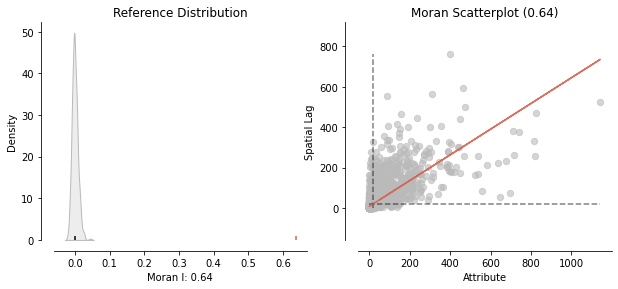

In [ ]:
plot_moran(moran_br, figsize=(10,4), zstandard = False);

In [ ]:
moran_loc_br = Moran_Local(y, w)

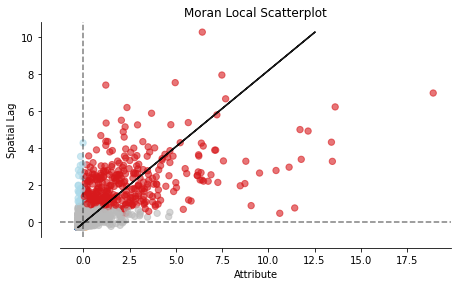

In [ ]:
moran_scatterplot(moran_loc_br, p=0.05);

## Tabela I de Moran

In [ ]:
mi_results = []
table_I = pd.DataFrame(dados_br.ano.unique(), columns=['anos'])

In [ ]:
for variavel in variaveis:
    mi_results = [Moran(dados_lisa[dados_lisa['ano']==ano][variavel].values, w) for ano in anos]
    table_p = pd.DataFrame([(round(res.I, 3)) for ano, res in zip(anos, mi_results)], columns=[variavel])
    table_I = pd.concat([table_I.reset_index(drop=True), table_p], axis=1)
table_I

,anos,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2006,0.562,0.002,0.161,0.239,0.030,0.179,0.320,0.167
1,2007,0.496,0.146,0.183,0.220,0.098,0.052,0.009,0.228
2,2008,0.471,0.303,0.298,0.326,0.402,0.558,0.611,0.448
3,2009,0.503,0.390,0.340,0.338,0.229,0.233,0.711,0.326
4,2010,0.477,0.345,0.292,0.292,0.178,0.136,0.532,0.239
5,2011,0.510,0.388,0.318,0.313,0.339,0.220,0.711,0.411
6,2012,0.542,0.443,0.377,0.378,0.223,0.520,0.729,0.420
7,2013,0.563,0.413,0.424,0.434,0.308,0.480,0.732,0.496
8,2014,0.590,0.434,0.409,0.417,0.299,0.392,0.786,0.453
9,2015,0.601,0.458,0.408,0.414,0.460,0.567,0.784,0.544


In [ ]:
#table_I.to_latex()

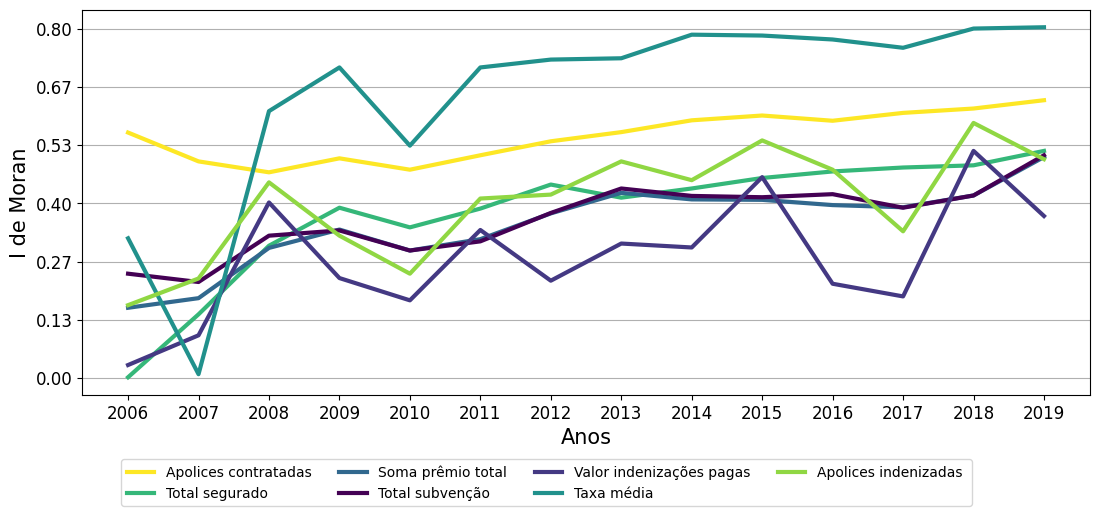

In [ ]:
f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(table_I['anos'])), table_I.apolices_contratadas, label='Apolices contratadas',markersize=7, color='#fde725', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.total_segurado_mil, label='Total segurado',markersize=7, color='#35b779', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.soma_premio_total_mil, label='Soma prêmio total',markersize=7, color='#31688e', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.total_subvencao_mil, label='Total subvenção',markersize=7, color='#440154', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.valor_indenizacoes_pagas_mil, label='Valor indenizações pagas',markersize=7, color='#443983', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.taxa_media, label='Taxa média',markersize=7, color='#21918c', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.apolices_indenizadas, label='Apolices indenizadas ',markersize=7, color='#90d743', linewidth=3)

ax.set_xticks(np.arange(len(table_I['anos'])))
ax.set_xticklabels(anos, fontsize = 12)
ax.set_ylabel('I de Moran', fontsize = 15)
ax.set_xlabel('Anos', fontsize = 15)

yvals = np.linspace(0,0.8, 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.2f}".format(y) for y in yvals], fontsize=12)
ax.yaxis.grid()

plt.legend(bbox_to_anchor=(0.89, -0.15), ncol=4)

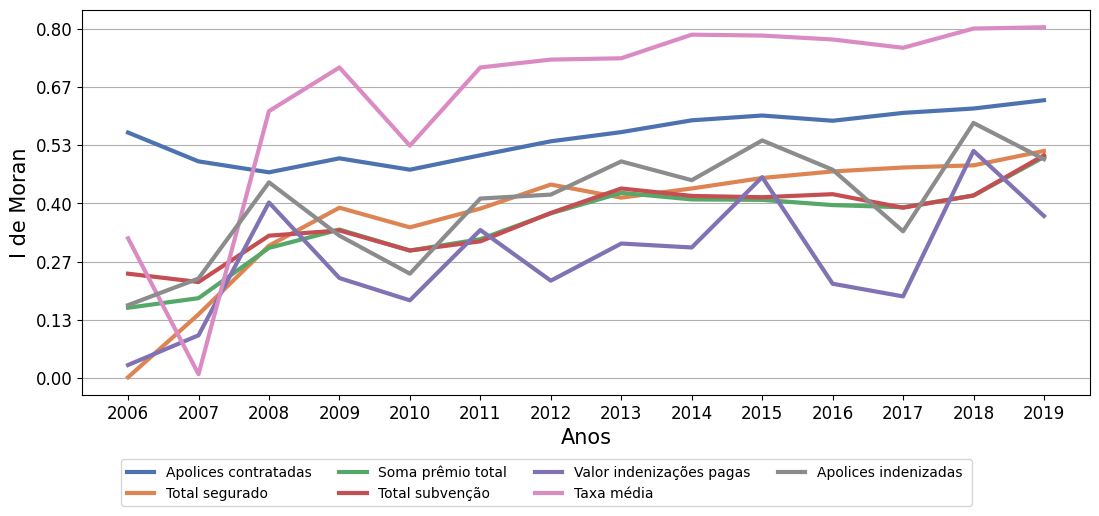

In [ ]:
f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(table_I['anos'])), table_I.apolices_contratadas, label='Apolices contratadas',markersize=7, color='#4c72b0', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.total_segurado_mil, label='Total segurado',markersize=7, color='#dd8452', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.soma_premio_total_mil, label='Soma prêmio total',markersize=7, color='#55a868', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.total_subvencao_mil, label='Total subvenção',markersize=7, color='#c44e52', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.valor_indenizacoes_pagas_mil, label='Valor indenizações pagas',markersize=7, color='#8172b3', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.taxa_media, label='Taxa média',markersize=7, color='#da8bc3', linewidth=3)
plt.plot(np.arange(len(table_I['anos'])), table_I.apolices_indenizadas, label='Apolices indenizadas ',markersize=7, color='#8c8c8c', linewidth=3)

ax.set_xticks(np.arange(len(table_I['anos'])))
ax.set_xticklabels(anos, fontsize = 12)
ax.set_ylabel('I de Moran', fontsize = 15)
ax.set_xlabel('Anos', fontsize = 15)

yvals = np.linspace(0,0.8, 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.2f}".format(y) for y in yvals], fontsize=12)
ax.yaxis.grid()

plt.legend(bbox_to_anchor=(0.89, -0.15), ncol=4)

ap_contrat    = Apolices contratadas    
t_segurado    = Total segurado   
soma_premio   = Soma prêmio total  
t_subvencao   = Total Subvenção mil  
inde_pagas    = Valor indenizações pagas mil  
sinis_media   = Sinistralidade média  
tx_media      = Taxa média  
ap_indeniz    = Apolices indenizadas  

In [ ]:
def moran_hot_cold_spots(moran_loc, p=0.05):
    sig = 1 * (moran_loc.p_sim < p)
    HH = 1 * (sig * moran_loc.q == 1)
    LL = 3 * (sig * moran_loc.q == 3)
    LH = 2 * (sig * moran_loc.q == 2)
    HL = 4 * (sig * moran_loc.q == 4)
    cluster = HH + LL + LH + HL
    return cluster

def mask_local_auto(moran_loc, p=0.5):
    
    # create a mask for local spatial autocorrelation
    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['não significativo', 'AA', 'BA', 'BB', 'AB']
    labels = [cluster_labels[i] for i in cluster]

    colors5 = {0: 'lightgrey',
               1: '#d7191c',
               2: '#abd9e9',
               3: '#2c7bb6',
               4: '#fdae61'}
    colors = [colors5[i] for i in cluster]  # for Bokeh
    # for MPL, keeps colors even if clusters are missing:
    x = np.array(labels)
    y = np.unique(x)

    colors5_mpl = {'AA': '#d7191c',
                   'BA': '#abd9e9',
                   'BB': '#2c7bb6',
                   'AB': '#fdae61',
                   'não significativo': 'lightgrey'}
    colors5 = [colors5_mpl[i] for i in y]  # for mpl

    # HACK need this, because MPL sorts these labels while Bokeh does not
    cluster_labels.sort()
    return cluster_labels, colors5, colors, labels

def lisa_cluster(moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs):

    # retrieve colors5 and labels from mask_local_auto
    _, colors5, _, labels = mask_local_auto(moran_loc, p=p)

    # define ListedColormap
    hmap = colors.ListedColormap(colors5)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0, ax=ax,
                               edgecolor='white', legend=False, # tirei a legenda aqui 
                               legend_kwds=legend_kwds, **kwargs)
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3)) # Adiciona linha dos estados 
    ax.set_axis_off()
    ax.set_aspect('equal')
    return fig, ax

In [ ]:
# cria a legenda LISA
labels = ['AA', 'BA', 'BB', 'AB', 'não significativo']
color_list = ["#d7191c", "#abd9e9", "#2c7bb6", "#fdae61", "lightgrey"]
hmap = colors.ListedColormap("", color_list)
lines = [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'

In [ ]:
# cria a legenda LISA para o EXEMPLO
labels = ['AA', 'BA', 'BB', 'AB', 'não significativo']
color_list = ["#d7191c", "#abd9e9", "#2c7bb6", "#fdae61", "lightgrey"]
hmap = colors.ListedColormap("", color_list)
lines = [Line2D([0], [0], color=c, marker='o', markersize=15, linestyle='') for c in color_list] # linewidth=20, linestyle='dotted'

y = dados_lisa[dados_lisa['ano'] == 2019]['apolices_contratadas'].values
moran_loc_br = Moran_Local(y, w)
f, ax = plt.subplots(figsize=(16,16)) # 
lisa_cluster(moran_loc_br, dados_19, p=0.05, ax=ax, figsize = (10,10))
ax.legend(lines, labels, loc='botton left', bbox_to_anchor=(1.08, 1), frameon=False,  prop={'size': 20})
plt.figimage(img2, 750, 25, zorder=1)
plt.show();

In [ ]:
for variavel in variaveis:
    f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
    anos = dados_br.ano.unique()
    axs = axs.flatten()
    for i, ano in enumerate(anos):
        ax = axs[i]
        y = dados_lisa[dados_lisa['ano'] == ano][variavel].values
        moran_loc_br = Moran_Local(y, w)
        lisa_cluster(moran_loc_br, dados_lisa[dados_lisa['ano']==ano], p=0.05, ax=ax, figsize = (10,10))
        ax.set_axis_off()
        ax.set_title(ano, fontsize=30)
        ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
    axs[13].legend(lines, labels, loc='botton left', bbox_to_anchor=(2, 0.75), frameon=False,  prop={'size': 25})
    axs[14].set_axis_off()
    axs[15].set_axis_off()
    axs[15].imshow(img)
    plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
    print(variavel)
    plt.show();

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# cria a legenda G loca
labels_g = ['Hot spot', 'Cool spot', 'não significativo']
color_list_g = ["#d7191c", "#2c7bb6", "lightgrey"]
hmap_g = colors.ListedColormap("", color_list_g)
lines_g= [Line2D([0], [0], color=c, marker='o', markersize=30, linestyle='') for c in color_list_g] # linewidth=20, linestyle='dotted'

In [ ]:
f, ax = plt.subplots(figsize=(10, 10)) # 
y = dados_lisa[dados_lisa['ano'] == 2019][variavel].values
g_loc_br = G_Local(y, w, star=True)
g_map(g_loc_br, dados_lisa[dados_lisa['ano']==2019], ax=ax)
ax.set_axis_off()
ax.set_title(ano, fontsize=30)
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
ax.legend(lines_g, labels_g, loc='botton left', bbox_to_anchor=(1.5, 0.75), frameon=False,  prop={'size': 25})
#axs[15].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
print(variavel)
plt.show();

In [ ]:
for variavel in variaveis:
    f, axs = plt.subplots(nrows=4, ncols=4, figsize=(30, 30)) # 
    anos = dados_br.ano.unique()
    axs = axs.flatten()
    for i, ano in enumerate(anos):
        ax = axs[i]
        y = dados_lisa[dados_lisa['ano'] == ano][variavel].values
        g_loc_br = G_Local(y, w, star=True)
        g_map(g_loc_br, dados_lisa[dados_lisa['ano']==ano], ax=ax)
        ax.set_axis_off()
        ax.set_title(ano, fontsize=30)
        ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
    axs[13].legend(lines_g, labels_g, loc='botton left', bbox_to_anchor=(2, 0.75), frameon=False,  prop={'size': 25})
    axs[14].set_axis_off()
    axs[15].set_axis_off()
    axs[15].imshow(img)
    plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.001, hspace=0.005)
    print(variavel)
    plt.show();

## Identificando grupos Lisa

In [ ]:
lisa_06 = dados_lisa[dados_lisa['ano'] == 2006]
y = dados_lisa[dados_lisa['ano'] == 2006]['apolices_indenizadas'].values
moran_loc_br = Moran_Local(y, w)
sig = moran_loc_br.p_sim < 0.05  # identificar significativos
posicoes = np.where(sig)    # municípios significativos
lisa_06['quad'] = moran_loc_br.q   # criar uma coluna nos dados identificando o quadrante

# Significativos
AA_06 = lisa_06.iloc[posicoes].query('quad == 1') # Alto-Alto
BA_06 = lisa_06.iloc[posicoes].query('quad == 2')  # Baixo-alto
BB_06 = lisa_06.iloc[posicoes].query('quad == 3') # Baixo-baixo
AB_06 = lisa_06.iloc[posicoes].query('quad == 4') # Alto-baixo

# Significativos ou não 
#AA_06 = lisa_06.query('quad == 1') # Alto-Alto
#BA_06 = lisa_06.query('quad == 2')  # Baixo-alto
#BB_06 = lisa_06.query('quad == 3') # Baixo-baixo
#AB_06 = lisa_06.query('quad == 4') # Alto-baixo

In [ ]:
lisa_19 = dados_lisa[dados_lisa['ano'] == 2019]
y = dados_lisa[dados_lisa['ano'] == 2019]['apolices_indenizadas'].values
moran_loc_br = Moran_Local(y, w)
sig = moran_loc_br.p_sim < 0.05  # identificar significativos   
posicoes = np.where(sig)    # municípios significativos
lisa_19['quad'] = moran_loc_br.q   # criar uma coluna nos dados identificando o quadrante

# Significativos
#AA_19 = lisa_19.iloc[posicoes].query('quad == 1') # Alto-Alto
#BA_19 = lisa_19.iloc[posicoes].query('quad == 2')  # Baixo-alto
#BB_19 = lisa_19.iloc[posicoes].query('quad == 3') # Baixo-baixo
#AB_19 = lisa_19.iloc[posicoes].query('quad == 4') # Alto-baixo

# Significativos ou não
AA_19 = lisa_19.query('quad == 1') # Alto-Alto
BA_19 = lisa_19.query('quad == 2')  # Baixo-alto
BB_19 = lisa_19.query('quad == 3') # Baixo-baixo
AB_19 = lisa_19.query('quad == 4') # Alto-baixo
# se queremos os municípios identificados como HL queremos o quadrante 4
# 1 - HH  
# 2 - LH  
# 3 - LL  
# 4 - HL

In [ ]:
(AA_06.groupby(['nome_regiao', 'nome_uf'])['quad'].count() / AA_06.groupby(['nome_uf', 'nome_regiao'])['quad'].count().sum()) * 100

nome_regiao  nome_uf          
Sudeste      Minas Gerais          3.1250
             São Paulo            31.2500
Sul          Paraná               23.4375
             Rio Grande do Sul    25.0000
             Santa Catarina       17.1875
Name: quad, dtype: float64

In [ ]:
round(54.819277 + 25.000000 + 2.409639, 2)

82.23

In [ ]:
(AA_19.groupby(['nome_regiao', 'nome_uf'])['quad'].count() / AA_19.groupby(['nome_uf', 'nome_regiao'])['quad'].count().sum()) * 100

## Tipos de transição 

In [ ]:
AA_AA = len(set.intersection(set(AA_06['mun']), set(AA_19['mun']))) # nº AA -> AA 
AB_AB = len(set.intersection(set(AB_06['mun']), set(AB_19['mun']))) 
BA_BA = len(set.intersection(set(BA_06['mun']), set(BA_19['mun'])))
BB_BB = len(set.intersection(set(BB_06['mun']), set(BB_19['mun'])))
F_0 = AA_AA + AB_AB + BA_BA + BB_BB

In [ ]:
BB_AB = len(set.intersection(set(BB_06['mun']), set(AB_19['mun']))) # nº BB -> AB
BA_AA = len(set.intersection(set(BA_06['mun']), set(AA_19['mun']))) 
AB_BB = len(set.intersection(set(AB_06['mun']), set(BB_19['mun'])))
AA_BA = len(set.intersection(set(AA_06['mun']), set(BA_19['mun'])))
F_I = BB_AB + BA_AA + AB_BB + AA_BA

In [ ]:
AB_AA = len(set.intersection(set(AB_06['mun']), set(AA_19['mun']))) # nº AB -> AA
AA_AB = len(set.intersection(set(AA_06['mun']), set(AB_19['mun']))) 
BA_BB = len(set.intersection(set(BA_06['mun']), set(BB_19['mun'])))
BB_BA = len(set.intersection(set(BB_06['mun']), set(BA_19['mun'])))
F_II = AB_AA + AA_AB + BA_BB + BB_BA

In [ ]:
AA_BB = len(set.intersection(set(AA_06['mun']), set(BB_19['mun']))) # nº AA -> BB
BB_AA = len(set.intersection(set(BB_06['mun']), set(AA_19['mun']))) 
BA_AB = len(set.intersection(set(BA_06['mun']), set(AB_19['mun'])))
AB_BA = len(set.intersection(set(AB_06['mun']), set(BA_19['mun'])))
F_III = AA_BB + BB_AA + BA_AB + AB_BA

In [ ]:
n = F_0 + F_I + F_II + F_III

In [ ]:
F_0/n

0.8122468429830831

In [ ]:
F_I/n

0.03979032642363593

In [ ]:
F_II/n

0.07672146771503455

In [ ]:
F_III/n

0.07124136287824637

## Gráficos descritivos

In [ ]:
sns.set_palette('muted')

In [ ]:
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
# Dados 
atlas_seg = pd.read_csv('https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/atlas_seguro_rural_anuais.csv',sep=';', decimal=',')

In [ ]:
#atlas_seg.head()
atlas_seg = atlas_seg[atlas_seg['Ano']!=2021]

### Apólices contratadas

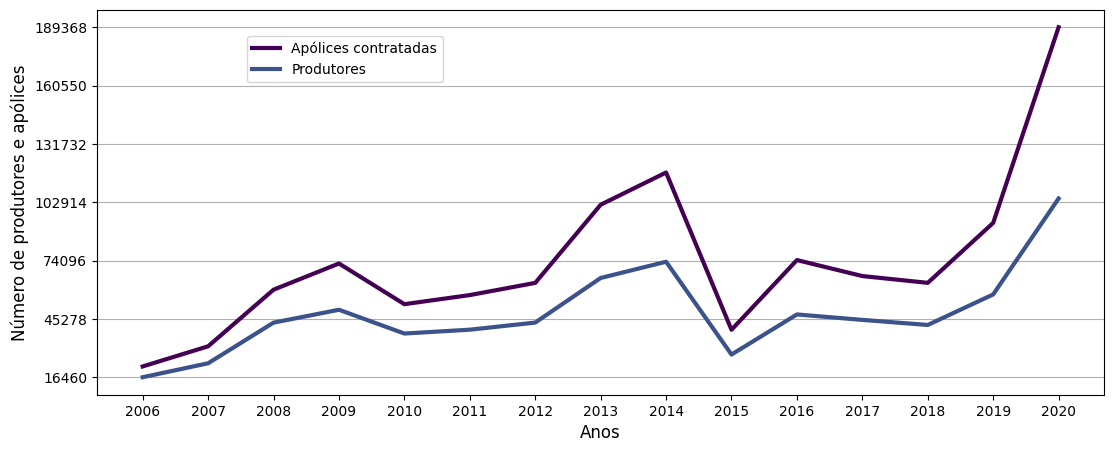

In [ ]:
#f, ax = plt.subplots(figsize=(9,4)) #
f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(atlas_seg.Ano)), atlas_seg.apolices, color='#440154', linewidth=3, label= "Apólices contratadas") # marker='o', markersize=7, 
plt.plot(np.arange(len(atlas_seg.Ano)), atlas_seg.produtores, color='#3b528b', linewidth=3, label="Produtores") # marker='o', markersize=7, 

yvals = np.linspace((atlas_seg.produtores).min(), (atlas_seg.apolices).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)

ax.set_xticks(np.arange(len(atlas_seg.Ano)))
ax.set_xticklabels(atlas_seg.Ano, fontsize = 10)
ax.set_ylabel('Número de produtores e apólices', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
plt.legend(bbox_to_anchor=(0.35, 0.95))


In [ ]:
round(np.mean(atlas_seg.apolices/atlas_seg.produtores),2)

1.48

In [ ]:
round(atlas_seg.apolices.max()/atlas_seg.apolices.min(),2)

8.69

In [ ]:
def anual_g(v_i, v_f, a_i, a_f):
    return round((v_f/v_i) ** (1/(a_f - a_i) - 1 ) * 100,2)

In [ ]:
anual_g(atlas_seg.apolices.min(), atlas_seg.apolices.max(), 2006, 2020)

13.42

In [ ]:
round(atlas_seg.produtores.max()/atlas_seg.produtores.min(),2)

6.36

### Valores do prêmio e de subvenção ao prêmio de seguro rural

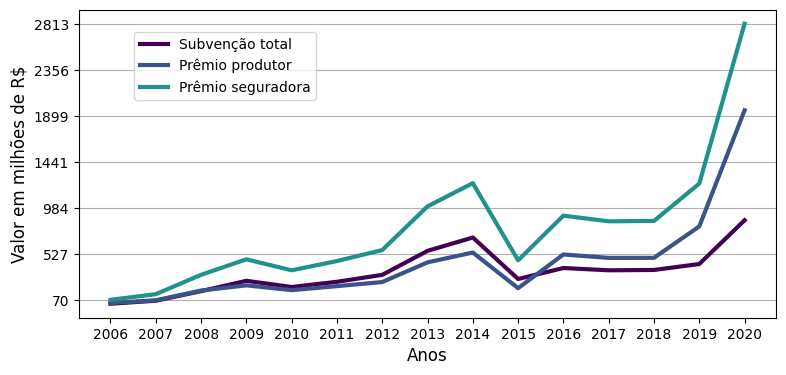

In [ ]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(atlas_seg.Ano)), atlas_seg['tot_subvencao']/1000000, color='#440154', linewidth=3, label="Subvenção total") # marker='o', markersize=7, 
plt.plot(np.arange(len(atlas_seg.Ano)), atlas_seg['premio_prod']/1000000, color='#3b528b', linewidth=3, label="Prêmio produtor") # marker='o', markersize=7, 
plt.plot(np.arange(len(atlas_seg.Ano)), atlas_seg['premio_seg']/1000000, color='#21918c', linewidth=3, label="Prêmio seguradora") # marker='o', markersize=7, 

ax.set_xticks(np.arange(len(atlas_seg.Ano)))
ax.set_xticklabels(atlas_seg.Ano, fontsize = 10)

yvals = np.linspace((atlas_seg['premio_seg']/1000000).min(), (atlas_seg['premio_seg']/1000000).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)

#yvals = ax.get_yticks()
#ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=12)

ax.set_ylabel('Valor em milhões de R\$', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
plt.legend(bbox_to_anchor=(0.35, 0.95));

In [ ]:
round(np.mean(atlas_seg.apolices/atlas_seg.produtores),2) 

1.48

In [ ]:
round(atlas_seg.apolices.max()/atlas_seg.apolices.min(),2)

8.69

In [ ]:
def anual_g(v_i, v_f, a_i, a_f):
    return round((v_f/v_i) ** (1/(a_f - a_i) - 1 ) * 100,2)

In [ ]:
anual_g(atlas_seg.apolices.min(), atlas_seg.apolices.max(), 2006, 2020)

13.42

In [ ]:
round(atlas_seg.produtores.max()/atlas_seg.produtores.min(),2)

6.36

### Total segurado

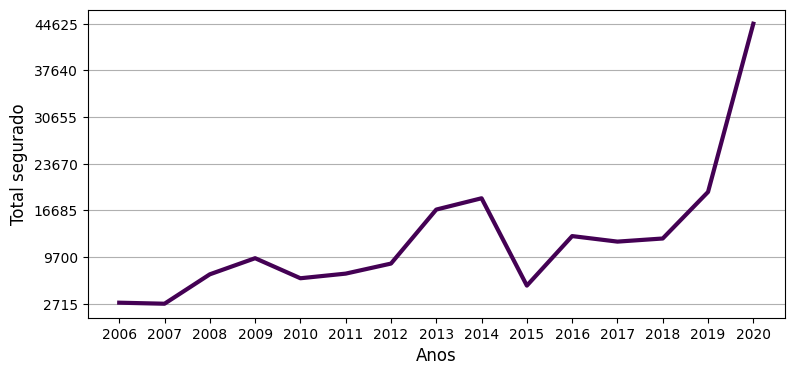

In [ ]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(atlas_seg.Ano)), atlas_seg['import_segurada']/1000000, color='#440154', linewidth=3) # label='Taxa média', marker='o', markersize=7, 
#plt.legend( bbox_to_anchor=(0.25, 0.95),)

ax.set_xticks(np.arange(len(atlas_seg.Ano)))
ax.set_xticklabels(atlas_seg.Ano, fontsize = 10)

yvals = np.linspace((atlas_seg['import_segurada']/1000000).min(), (atlas_seg['import_segurada']/1000000).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)
#yvals = ax.get_yticks()
ax.set_ylabel('Total segurado', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()

In [ ]:
import_seg = atlas_seg.import_segurada/1000000

In [ ]:
round(import_seg.max() / import_seg[0],2)

15.55

In [ ]:
round(import_seg[14]/import_seg[13],2)

2.3

### Taxa média de contratação de seguro rural

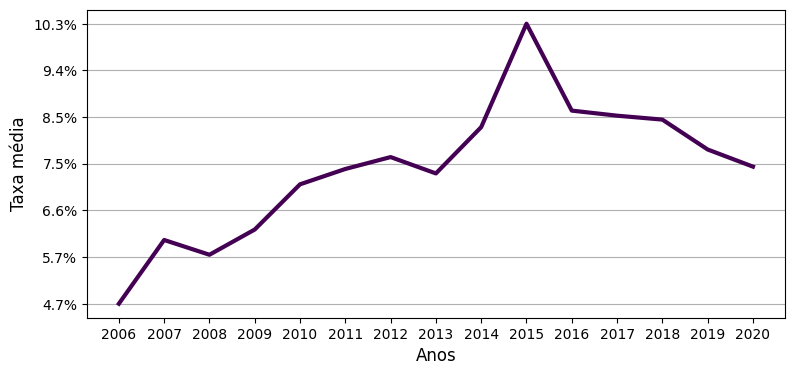

In [ ]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(atlas_seg.Ano)), atlas_seg.taxa_media, color='#440154', linewidth=3) # label='Taxa média', marker='o', markersize=7, 

#for x,y in zip(np.arange(len(atlas_seg.Ano)), atlas_seg['taxa_media']):

#    label = "{:,.1%}".format(y)

#    plt.annotate(label, # this is the text
#                 (x,y), # these are the coordinates to position the label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,3), # distance from text to points (x,y)
#                 ha='center') # horizontal alignment can be left, right or center

ax.set_xticks(np.arange(len(atlas_seg.Ano)))
ax.set_xticklabels(atlas_seg.Ano, fontsize = 10)

yvals = np.linspace((atlas_seg.taxa_media).min(), (atlas_seg.taxa_media).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:,.1%}".format(y) for y in yvals], fontsize=10)

ax.set_ylabel('Taxa média', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
#plt.legend( bbox_to_anchor=(0.25, 0.95),)


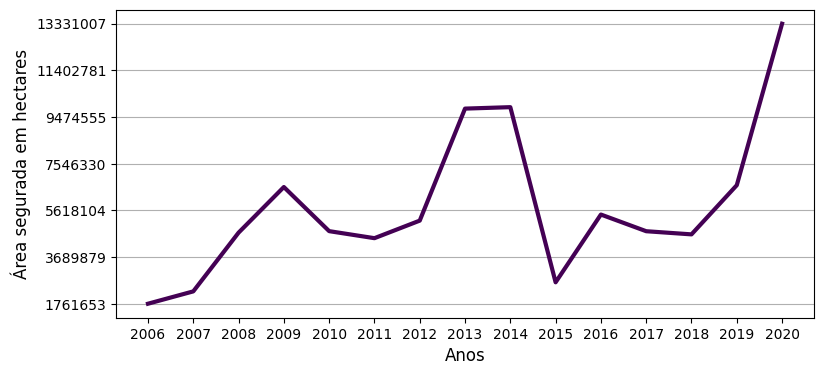

In [ ]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(atlas_seg.Ano)), atlas_seg.area_segurada, color='#440154', linewidth=3, label= "Área segurada em hectares") # marker='o', markersize=7, 

yvals = np.linspace((atlas_seg.area_segurada).min(), (atlas_seg.area_segurada).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)

ax.set_xticks(np.arange(len(atlas_seg.Ano)))
ax.set_xticklabels(atlas_seg.Ano, fontsize = 10)
ax.set_ylabel('Área segurada em hectares', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid()
#plt.legend( bbox_to_anchor=(0.25, 0.95),)

In [ ]:
df_soma_anos = dados_br.groupby('ano').sum()
df_soma_anos.reset_index(level = 0, inplace = True)

In [ ]:
variaveis

['apolices_contratadas',
 'total_segurado_mil',
 'soma_premio_total_mil',
 'total_subvencao_mil',
 'valor_indenizacoes_pagas_mil',
 'sinistralidade_media',
 'taxa_media',
 'apolices_indenizadas']

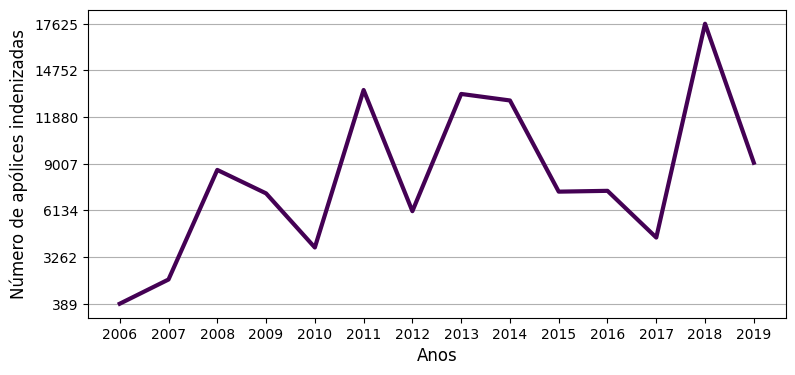

In [ ]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(df_soma_anos['ano'])), df_soma_anos['apolices_indenizadas'], label='Apólices indenizadas', color='#440154', linewidth=3)

yvals = np.linspace((df_soma_anos['apolices_indenizadas']).min(), (df_soma_anos['apolices_indenizadas']).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)

ax.set_xticks(np.arange(len(df_soma_anos['ano'])))
ax.set_xticklabels(anos, fontsize = 10)
ax.set_ylabel('Número de apólices indenizadas', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 12)
ax.yaxis.grid();

In [ ]:
round(df_soma_anos.apolices_indenizadas[13]/ df_soma_anos.apolices_indenizadas[0],2)

23.31

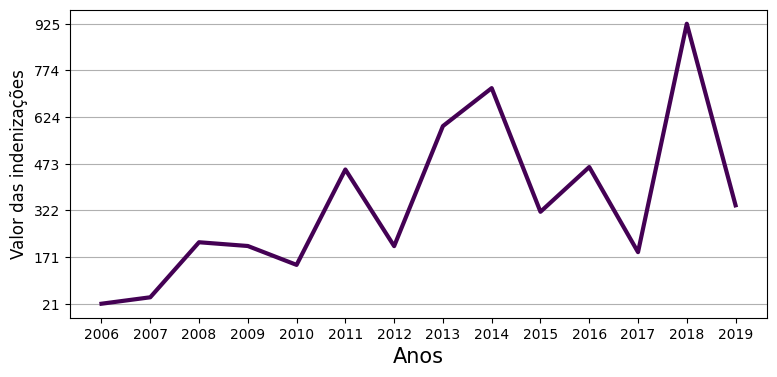

In [ ]:
f, ax = plt.subplots(figsize=(9,4)) #f, ax = plt.subplots(figsize=(13,5)) # 

plt.plot(np.arange(len(df_soma_anos['ano'])), df_soma_anos['valor_indenizacoes_pagas_mil']/1000000, label='Valor indenizações pagas', color='#440154', linewidth=3)

yvals = np.linspace((df_soma_anos['valor_indenizacoes_pagas_mil']/1000000).min(), (df_soma_anos['valor_indenizacoes_pagas_mil']/1000000).max(), 7)
ax.set_yticks(yvals)
ax.set_yticklabels(["{:.0f}".format(y) for y in yvals], fontsize=10)


ax.set_xticks(np.arange(len(df_soma_anos['ano'])))
ax.set_xticklabels(anos, fontsize = 10)
ax.set_ylabel('Valor das indenizações', fontsize = 12)
ax.set_xlabel('Anos', fontsize = 15)
ax.yaxis.grid();

In [ ]:
dados_cult = pd.read_csv('https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/dados_cult_f.csv')

In [ ]:
apolices_anos = df_soma_anos['apolices_contratadas']
soja = (dados_cult[dados_cult['cultura']=="Soja"]['apolices_contratadas'].values / apolices_anos.values) * 100
milho_1 = (dados_cult[dados_cult['cultura']=='Milho 1ª safra']['apolices_contratadas'].values / apolices_anos.values) * 100
milho_2 = (np.concatenate([[0], dados_cult[dados_cult['cultura']=='Milho 2ª safra']['apolices_contratadas'].values]) / apolices_anos.values) * 100
maca = (dados_cult[dados_cult['cultura']=='Maçã']['apolices_contratadas'].values / apolices_anos.values) * 100
uva = (dados_cult[dados_cult['cultura']=="Uva"]['apolices_contratadas'].values / apolices_anos.values) * 100
#algodao = (dados_cult[dados_cult['cultura']=='Algodão']['apolices_contratadas'].values / apolices_anos.values) * 100
cana = (dados_cult[dados_cult['cultura']=='Cana-de-açúcar']['apolices_contratadas'].values / apolices_anos.values) * 100
#floresta = (dados_cult[dados_cult['cultura']== 'Floresta']['apolices_contratadas'].values / apolices_anos.values) * 100
#pecuaria = (dados_cult[dados_cult['cultura']=='Pecuário']['apolices_contratadas'].values / apolices_anos.values) * 100
outros = np.array(soja + milho_1 + milho_2 + maca + uva + cana)/100
outros = (np.ones(14) - outros )* 100

In [ ]:
milho_1.max(), milho_1.min(), milho_1.std(), milho_1.mean()

(16.46765252633518, 1.2329775487670225, 4.531294948438938, 6.155098898259644)

In [ ]:
culturas_prc = pd.DataFrame(anos, columns=['anos'])
culturas_prc['soja'] = soja.tolist()
culturas_prc['milho_1'] = milho_1
culturas_prc['milho_2'] = milho_2
culturas_prc['maca'] = maca
culturas_prc['uva'] = uva
#culturas_prc['algodao'] = algodao
culturas_prc['cana'] =  cana
#culturas_prc['floresta'] = floresta
#culturas_prc['pecuaria'] = pecuaria
culturas_prc['outros'] = outros

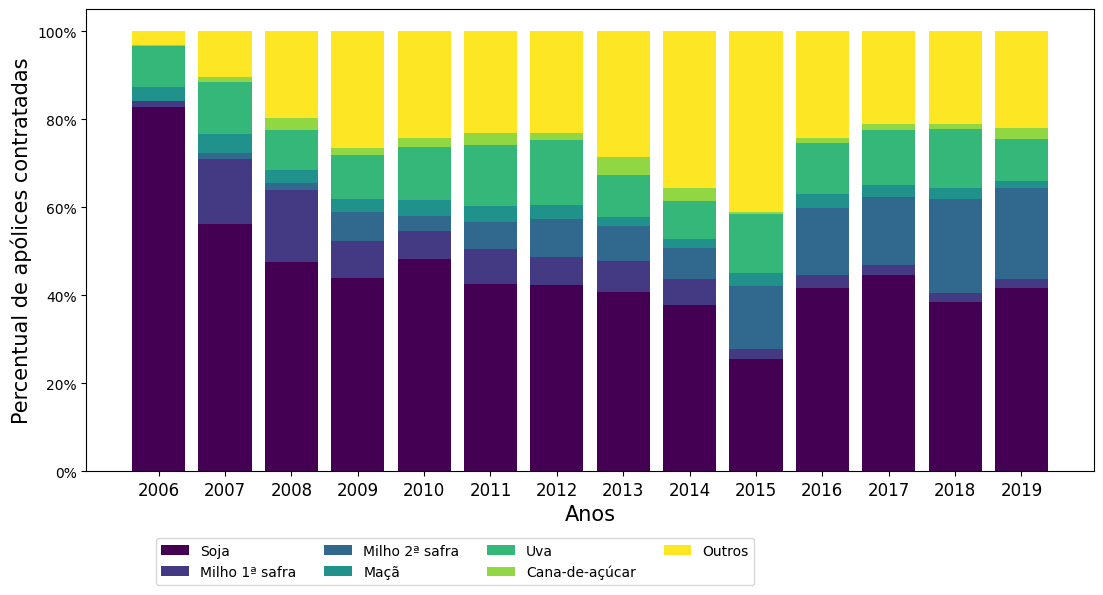

In [ ]:
f, ax = plt.subplots(figsize=(13,6)) # 

pos = np.arange(len(anos))

plt.bar(pos, soja, label='Soja',color='#440154')
plt.bar(pos, milho_1, bottom = soja, label='Milho 1ª safra',color='#443983')
plt.bar(pos, milho_2, bottom = soja + milho_1, label='Milho 2ª safra', color='#31688e')
plt.bar(pos, maca, bottom = soja + milho_1 + milho_2, label='Maçã', color='#21918c')
plt.bar(pos, uva, bottom = soja + milho_1 + milho_2 + maca, label='Uva', color='#35b779')
#plt.bar(pos, algodao, bottom = soja + milho_1 + milho_2 + maca + uva, label='Algodão')
plt.bar(pos, cana, bottom = soja + milho_1 + milho_2 + maca + uva, label='Cana-de-açúcar',color='#90d743')
#plt.bar(pos, floresta, bottom = soja + milho_1 + milho_2 + maca + uva + algodao + cana, label='Floresta')
#plt.bar(pos, pecuaria, bottom = soja + milho_1 + milho_2 + maca + uva + algodao + cana + floresta, label='Pecuária')
plt.bar(pos, outros, bottom = soja + milho_1 + milho_2 + maca + uva + cana, label='Outros',color='#fde725')
ax.set_xticks(pos)
ax.set_xticklabels(anos, fontsize = 12)
ax.set_ylabel('Percentual de apólices contratadas', fontsize = 15)
ax.set_xlabel('Anos', fontsize = 15)
fmt = '%.0f%%' 
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
#plt.legend(bbox_to_anchor=(0.23, 0.4))
plt.legend(bbox_to_anchor=(0.67, -0.13), ncol=4)
plt.show() 

In [ ]:
sns.set_palette("muted")

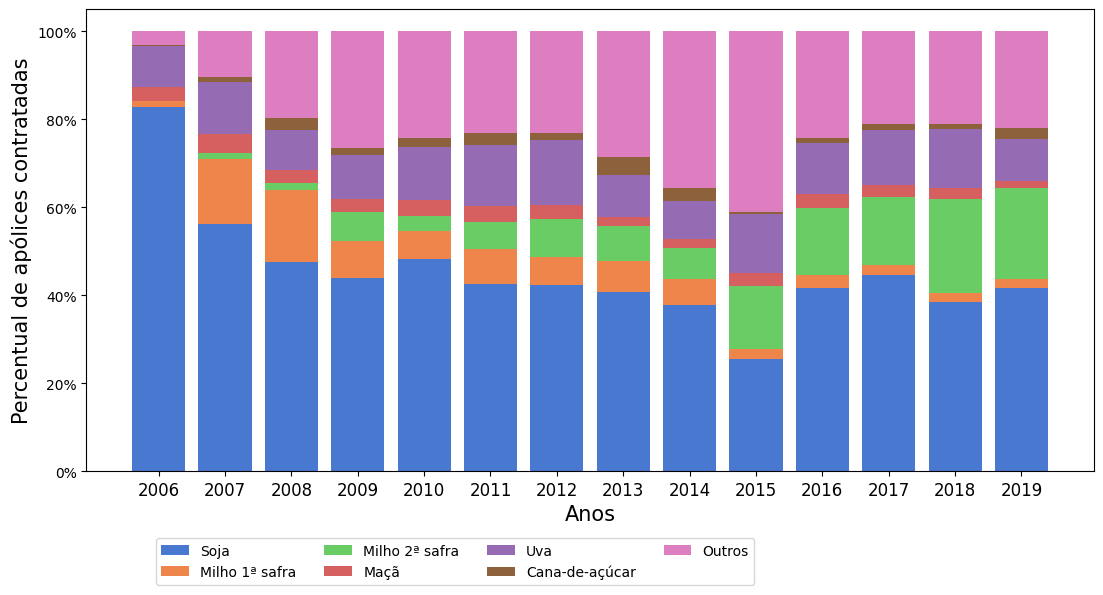

In [ ]:
f, ax = plt.subplots(figsize=(13,6)) # 

pos = np.arange(len(anos))

plt.bar(pos, soja, label='Soja')
plt.bar(pos, milho_1, bottom = soja, label='Milho 1ª safra')
plt.bar(pos, milho_2, bottom = soja + milho_1, label='Milho 2ª safra')
plt.bar(pos, maca, bottom = soja + milho_1 + milho_2, label='Maçã')
plt.bar(pos, uva, bottom = soja + milho_1 + milho_2 + maca, label='Uva')
#plt.bar(pos, algodao, bottom = soja + milho_1 + milho_2 + maca + uva, label='Algodão')
plt.bar(pos, cana, bottom = soja + milho_1 + milho_2 + maca + uva, label='Cana-de-açúcar')
#plt.bar(pos, floresta, bottom = soja + milho_1 + milho_2 + maca + uva + algodao + cana, label='Floresta')
#plt.bar(pos, pecuaria, bottom = soja + milho_1 + milho_2 + maca + uva + algodao + cana + floresta, label='Pecuária')
plt.bar(pos, outros, bottom = soja + milho_1 + milho_2 + maca + uva + cana, label='Outros')
ax.set_xticks(pos)
ax.set_xticklabels(anos, fontsize = 12)
ax.set_ylabel('Percentual de apólices contratadas', fontsize = 15)
ax.set_xlabel('Anos', fontsize = 15)
fmt = '%.0f%%' 
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
#plt.legend(bbox_to_anchor=(0.23, 0.4))
plt.legend(bbox_to_anchor=(0.67, -0.13), ncol=4)
plt.show() 

## Diagrama de dispersão de Moran - Simulação

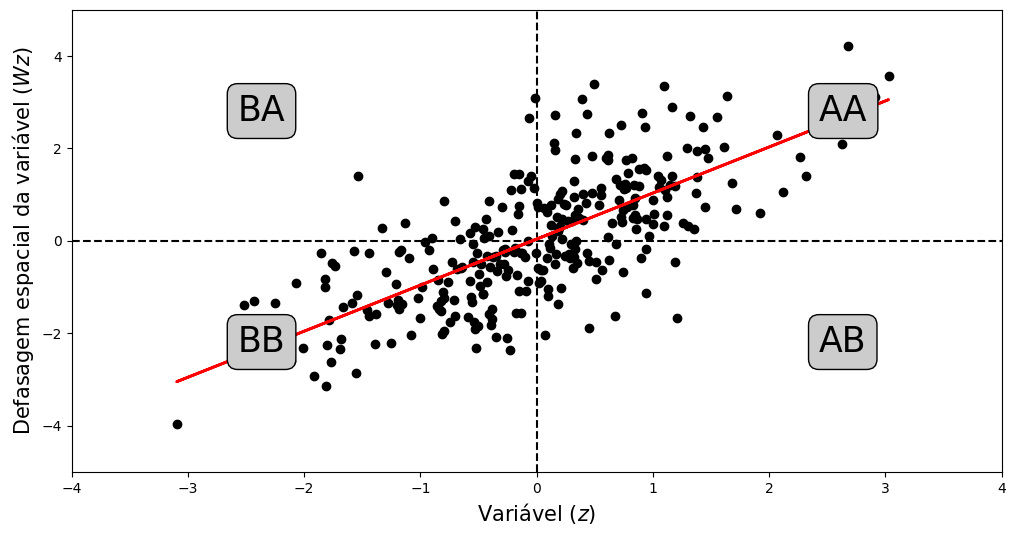

In [ ]:
from sklearn.linear_model import LinearRegression
x = np.random.randn(300)
y = 0.98 * x + np.random.randn(300)

nx = np.reshape(x, (-1, 1))
ny = np.reshape(y, (-1, 1))
model = LinearRegression()
model.fit(nx, ny)
fig, ax = plt.subplots(figsize=(12,6))

plt.ylim(-5,5)
plt.xlim(-4,4)
plt.axhline(0, color='black', linestyle = 'dashed')
plt.axvline(0, color='black', linestyle = 'dashed')

ax.annotate('AA', xy=(2.5, 2.5), size=25,
    xytext=(-6, 3), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.8"))
ax.annotate('AB', xy=(2.5, -2.5), size=25,
    xytext=(-6, 3), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.8"))      
ax.annotate('BA', xy=(-2.5, 2.5), size=25,
    xytext=(-6, 3), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.8"))
ax.annotate('BB', xy=(-2.5, -2.5), size=25,
    xytext=(-6, 3), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.8"))

ax.set_xlabel('Variável ($z$)', fontsize = 15)
ax.set_ylabel('Defasagem espacial da variável ($Wz$)', fontsize = 15)

ax.plot(nx, model.predict(nx), color='red',linewidth=2)
ax.scatter(nx, ny, color ='black');